In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fresnel_coro_2dm as fresnel
import apra_pop_models.fraunhofer_coro_2dm as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
import apra_pop_models.pwp as pwp

from apra_pop_models.imshows import *

pupil_diam = 9.5*u.mm
wavelength_c = 650e-9*u.m


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


In [2]:
reload(fresnel)
coro = fresnel.CORO()
coro.npsf = 200
coro.Imax_ref = 0.01867821

coro.use_opds = True
coro.Imax_ref = 0.01795029

# pup_ratio = coro.pupil_diam.to_value(u.m)/coro.dm_active_diam.to_value(u.m)
# xpp = (xp.arange(-coro.Nact//2, coro.Nact//2) + 1/2)/pup_ratio
# ppx, ppy = xp.meshgrid(xpp,xpp)
# amp = 5e-8
# separation = 5
# comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/coro.Nact)*xp.array(coro.dm_mask)
# comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/coro.Nact)*xp.array(coro.dm_mask)
# coro.set_dm1(ensure_np_array(comm1))
# coro.set_dm2(ensure_np_array(comm2))

ref_psf = coro.snap()

coro.use_fpm = True
ref_im = coro.snap()

imshow2(ref_psf, ref_im, lognorm=True, vmin1=xp.max(ref_psf)/1e5, vmin2=1e-12,
        pxscl=coro.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((coro.psf_pixelscale_lamD/2,coro.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan')])

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


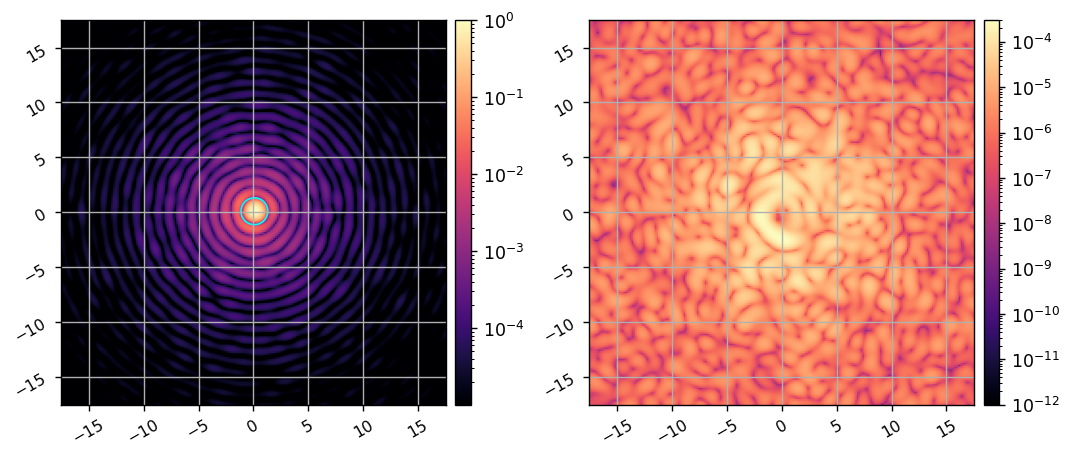

In [3]:
reload(fraunhofer)
reload(apra_pop_models.props)
model = fraunhofer.CORO()
model.npsf = 200
# model.reverse_parity = True

model.Imax_ref = 12448.951927281492

# WFE = xp.array(fits.getdata('../phase-retrieval-data/post_fpm_wfe_20240503.fits'))
WFE = xp.array(fits.getdata('../phase-retrieval-data/post_fpm_wfe_20240505.fits'))
WFE = WFE[0] * xp.exp(1j*2*np.pi*WFE[1]/wavelength_c.to_value(u.m))
wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength_c.to_value(u.m)/(2*np.pi)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[model.APMASK]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[model.APMASK])))
# imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
model.WFE = WFE
# model.WFE = xp.rot90(xp.rot90(WFE))
model.Imax_ref = 0.017874510571953023

# pup_ratio = model.pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
# xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio
# ppx, ppy = xp.meshgrid(xpp,xpp)
# amp = 5e-8
# separation = 5
# comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# model.set_dm1(ensure_np_array(comm1))
# model.set_dm2(ensure_np_array(comm2))

model_psf = model.snap()

model.use_fpm = True
model_im = model.snap()

imshow2(model_psf, model_im, lognorm=True, vmin1=xp.max(model_psf)/1e5, vmin2=1e-12,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan')])




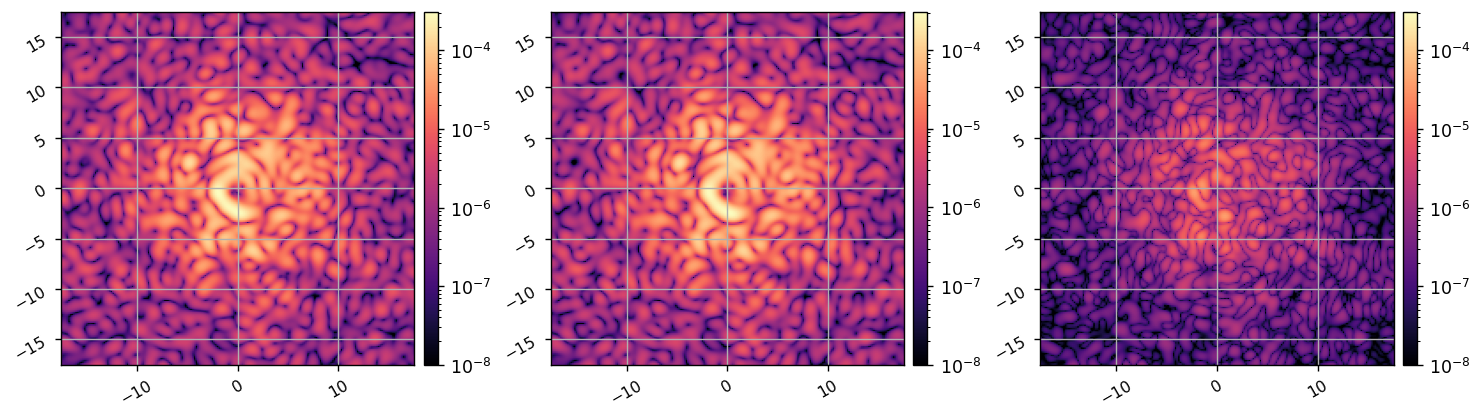

In [4]:
reload(apra_pop_models.imshows)
from apra_pop_models.imshows import *

diff = ref_im - model_im
imshow3(ref_im, model_im, xp.abs(diff), 
        lognorm1=True, lognorm2=True, vmin1=1e-8, vmin2=1e-8, 
        lognorm3=True, vmin3=1e-8, vmax3=xp.max(ref_im),
        pxscl=model.psf_pixelscale_lamD, grid=True,)

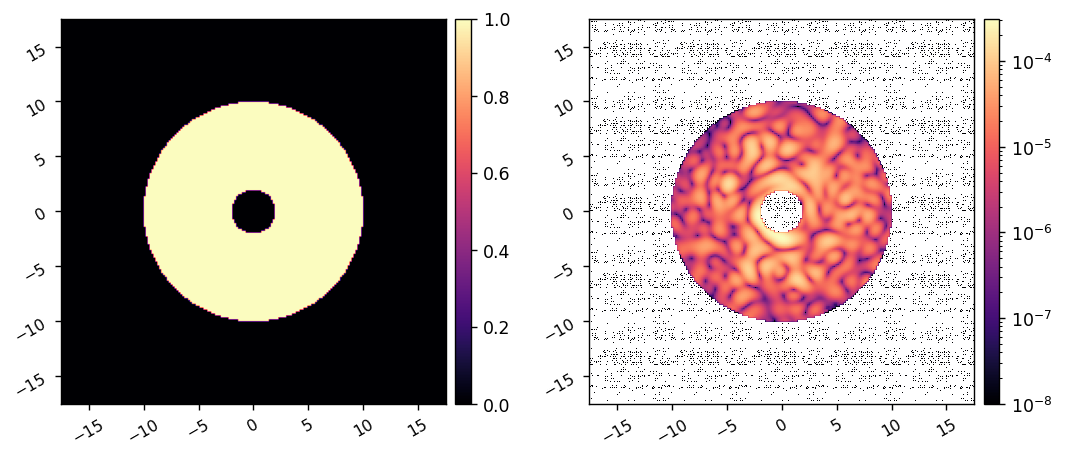

In [5]:
control_mask = efc_utils.create_annular_focal_plane_mask(model, 2, 10)
imshow2(control_mask, control_mask*ref_im, lognorm2=True, vmin2=1e-8, pxscl=model.psf_pixelscale_lamD)

In [6]:
poke_modes = efc_utils.create_all_poke_modes(model.dm_mask, ndms=2)


Calculating Jacobian: 
	Calculated response for mode 1904/1904. Elapsed time=87.118 sec.
Jacobian built in 87.118 sec


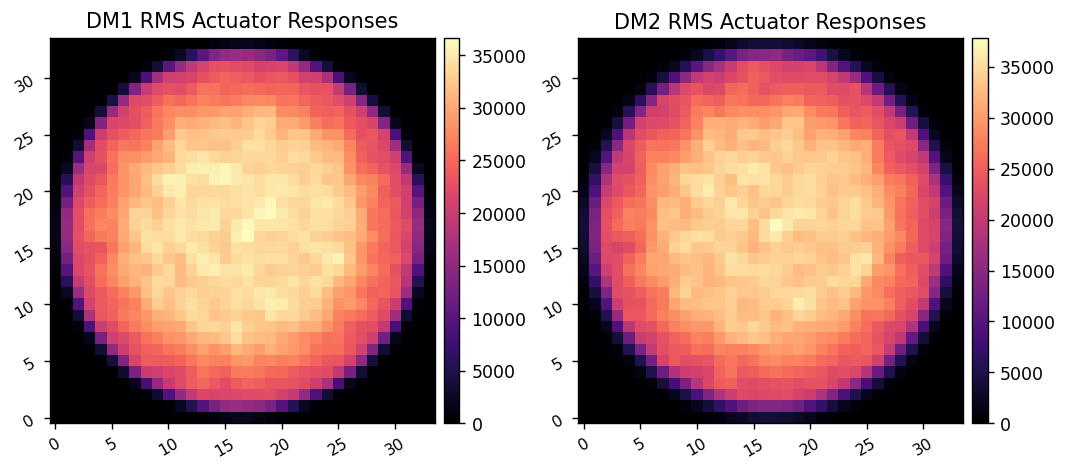

In [7]:
reload(efc)
jac = efc.build_jacobian(model, 1e-9, poke_modes, control_mask, plot_responses=True,)

# Test PWP

In [9]:
reload(efc_utils)
Npairs = 3

# probe_amp = 2e-9
# probe_mask = efc_utils.create_annular_focal_plane_mask(model, inner_radius=1, outer_radius=12, edge=0, plot=True)
# probe_modes = efc_utils.create_fourier_probes(model, probe_mask, fourier_sampling=0.25, 
#                                                shift=[(-8, 7), (8,7), (0,-9)], 
#                                                nprobes=Npairs, 
#                                              #   use_weighting=True,
#                                                )
# probes = probe_amp * probe_modes
# imshow3(probes[0], probes[1], probes[2])

probe_amp = 2*10e-10
probes = probe_amp*efc_utils.create_random_probes(rms=probe_amp, alpha=1, dm_mask=model.dm_mask, fmin=1.5, fmax=12, nprobes=3)
imshow3(probes[0], probes[1], probes[2])

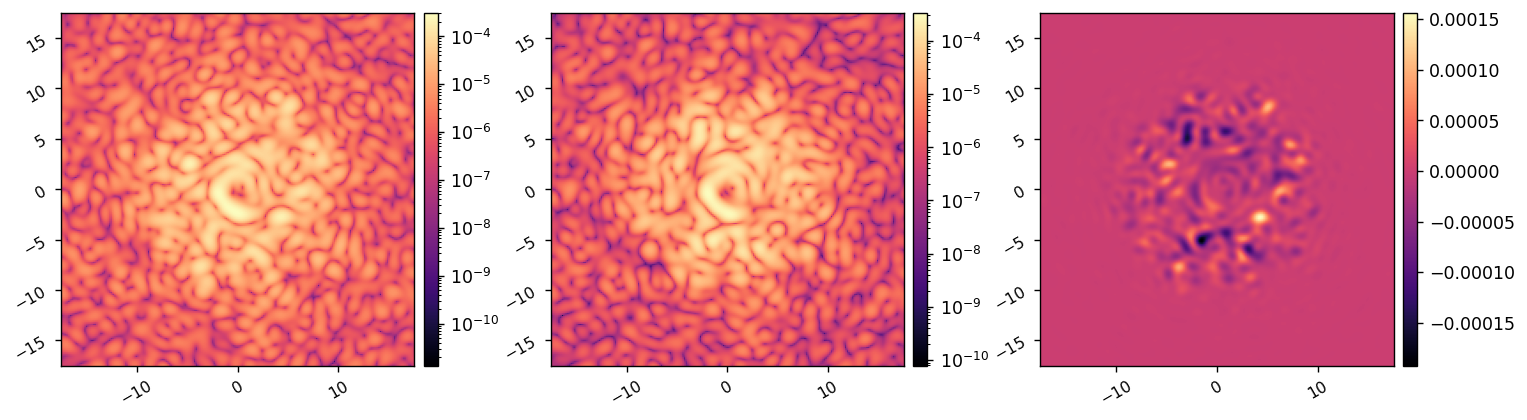

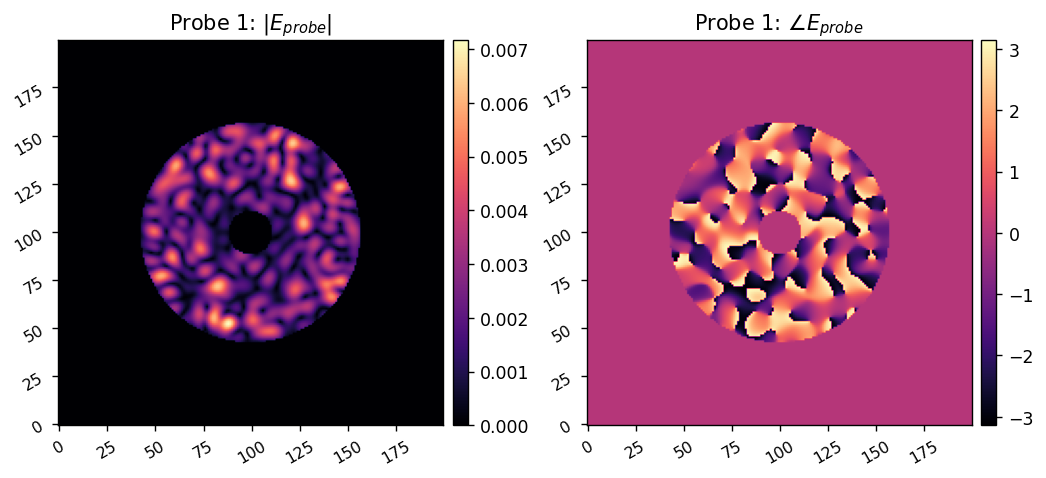

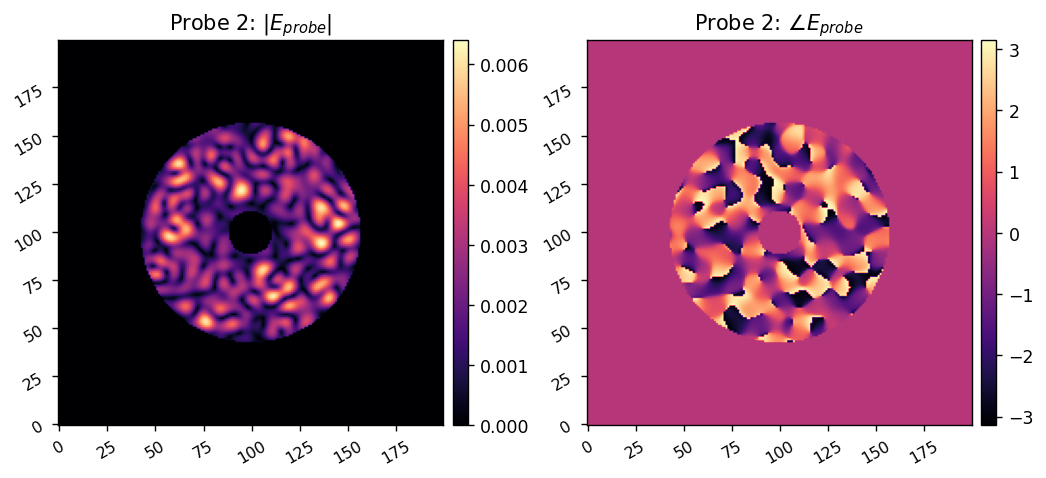

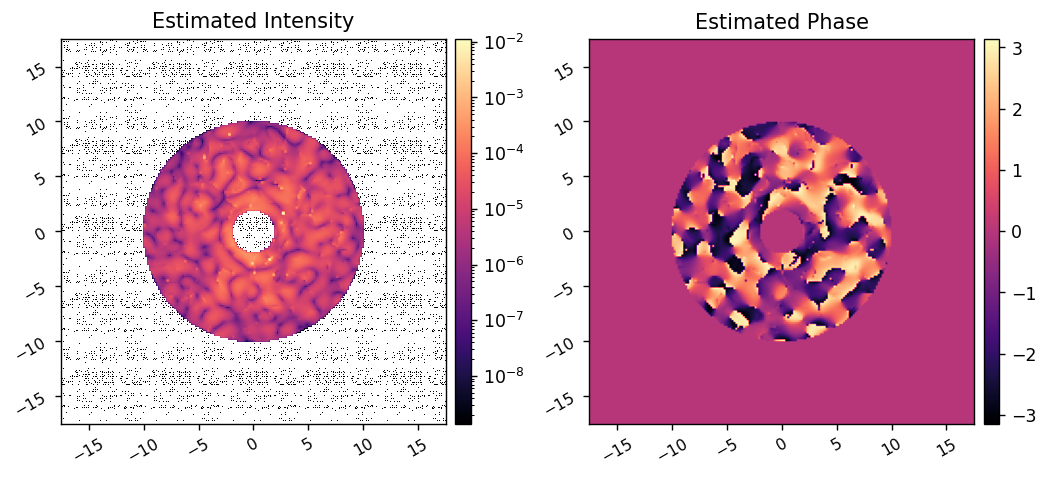

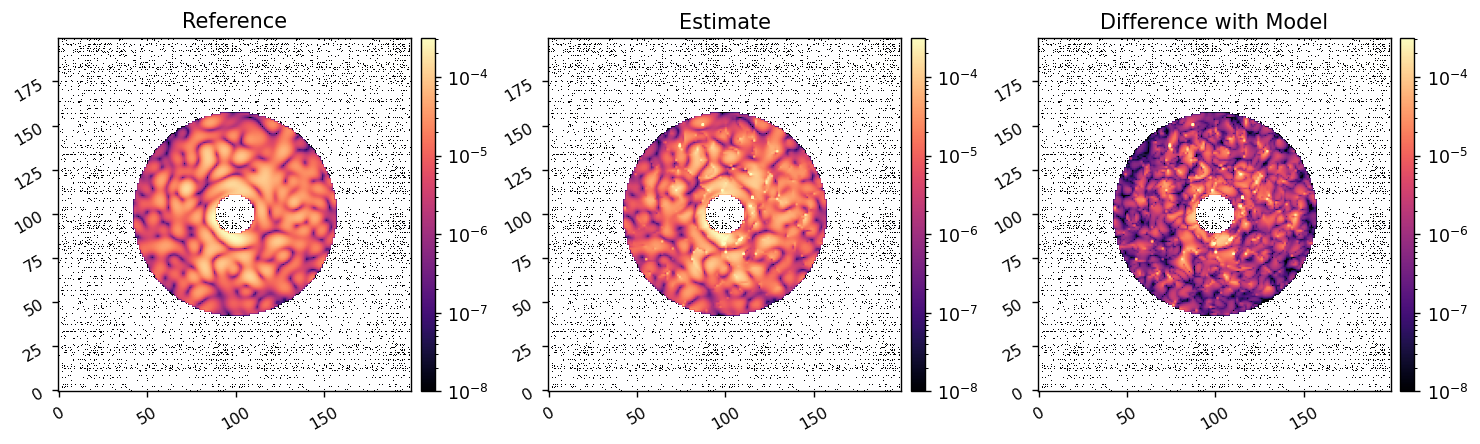

In [10]:
reload(pwp)
model.reset_dms()
E_est = pwp.run_pwp_bp(coro, control_mask, probes, use='J', jacobian=jac, 
                       reg_cond=1e-6,
                       plot=True,
                       plot_est=True,
                       )
I_est = np.abs(E_est)**2
P_est = np.angle(E_est)

diff = ref_im*control_mask - I_est
# vmax = xp.max(xp.concatenate([ref_im*control_mask, I_est]))
vmax = xp.max(ref_im*control_mask)
imshow3(ref_im*control_mask, I_est, xp.abs(diff),
        'Reference', 'Estimate', 'Difference with Model',
        lognorm=True, 
        vmax1=vmax, vmax2=vmax, vmax3=vmax,
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

# Run EFC without PWP

In [13]:
coro.reset_dms()
model.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([coro.get_dm1()])
dm2_commands = xp.array([coro.get_dm2()])
regs = xp.array([])

Beginning closed-loop EFC simulation.
	Running iteration 10/12.
	Mean NI of this iteration: 2.324e-10


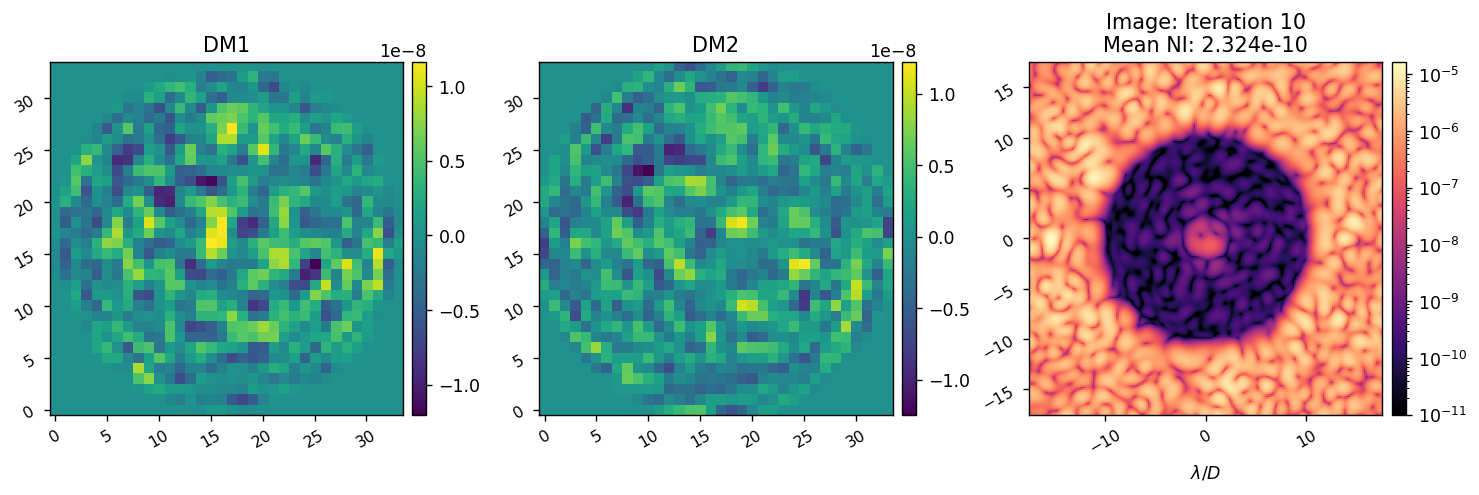

	Running iteration 11/12.
	Mean NI of this iteration: 1.171e-10


	Running iteration 12/12.
	Mean NI of this iteration: 7.313e-11


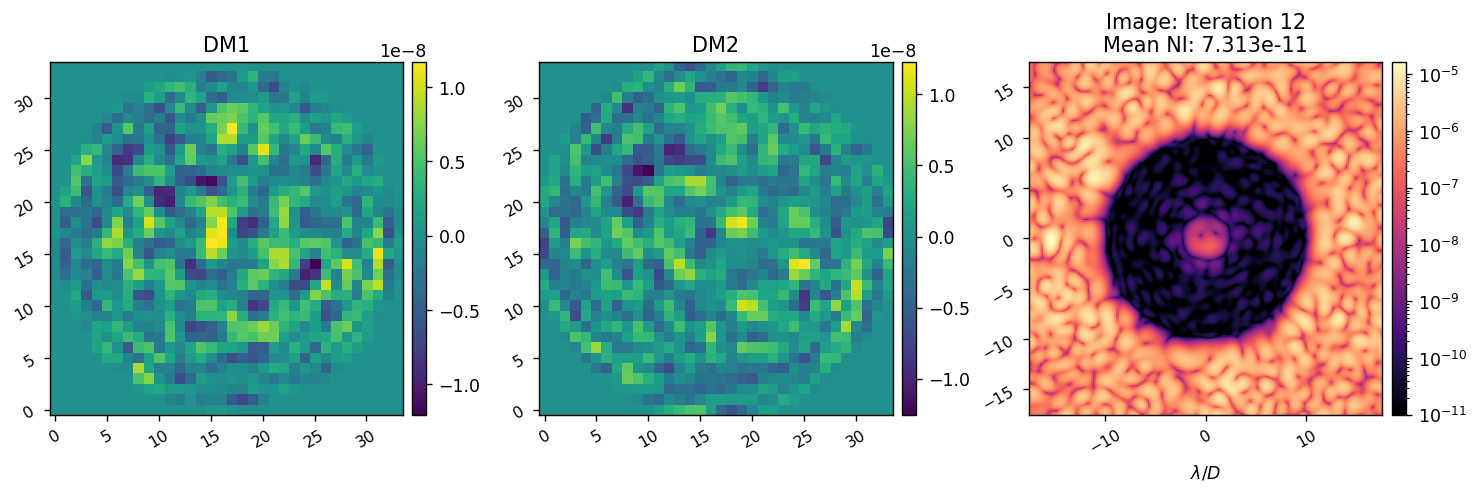

EFC completed in 4.243 sec.


In [17]:
reload(efc)

reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

images, dm1_commands, dm2_commands, regs = efc.run(coro, 
                                                    jac, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    control_mask, 
                                                    # est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=dm1_commands,
                                                    old_dm2_commands=dm2_commands,
                                                    old_regs=regs,
                                                    )

# Run EFC with PWP

In [20]:
coro.reset_dms()
model.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([coro.get_dm1()])
dm2_commands = xp.array([coro.get_dm2()])
regs = xp.array([])

Beginning closed-loop EFC simulation.
	Running iteration 13/15.


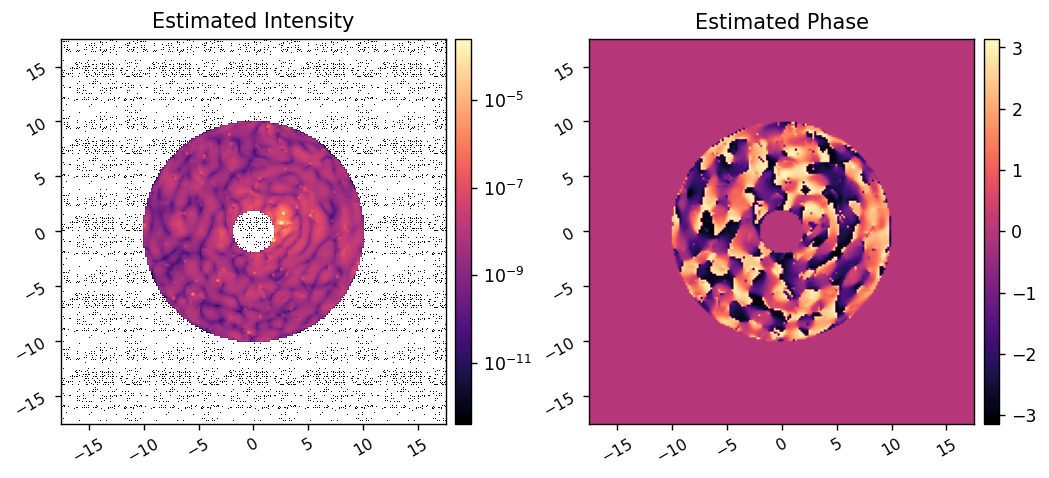

	Mean NI of this iteration: 1.298e-08


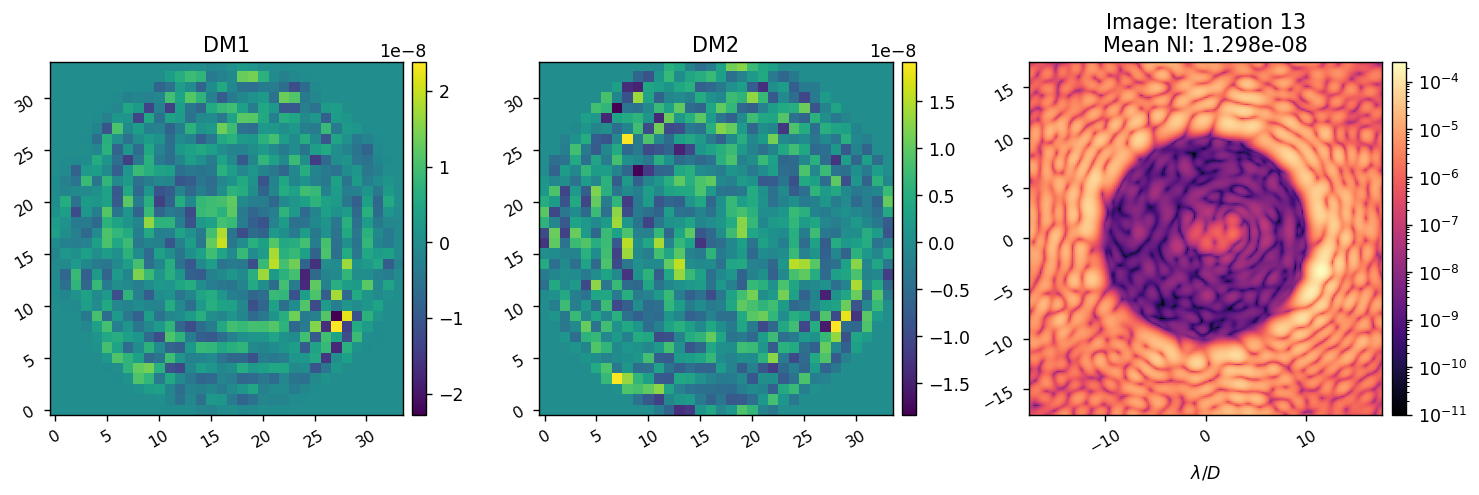

	Running iteration 14/15.


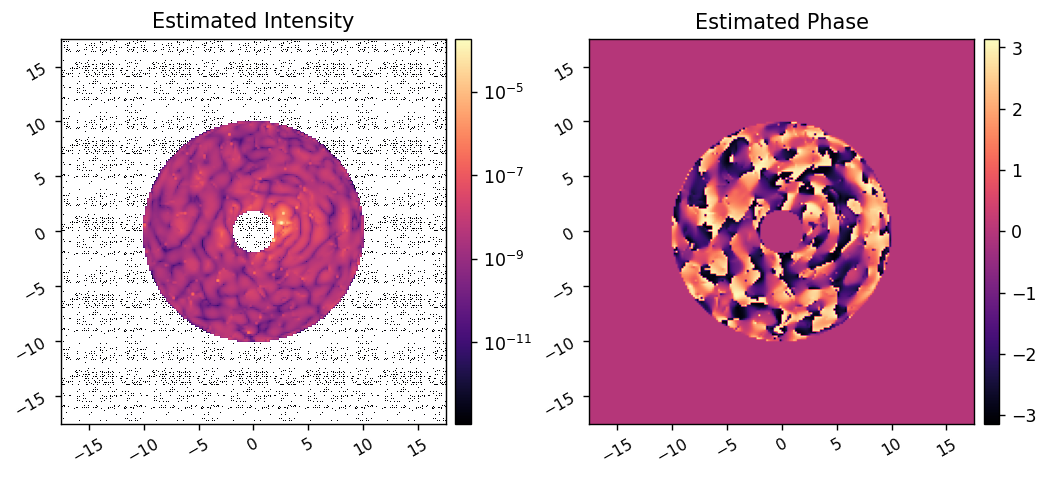

	Mean NI of this iteration: 9.986e-09


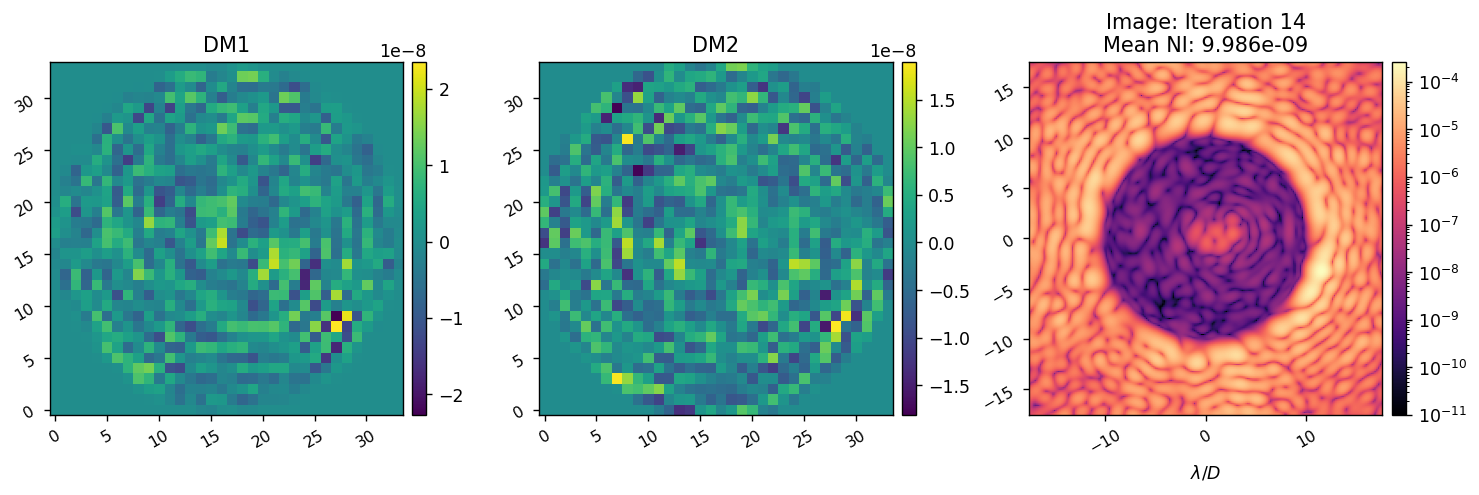

	Running iteration 15/15.


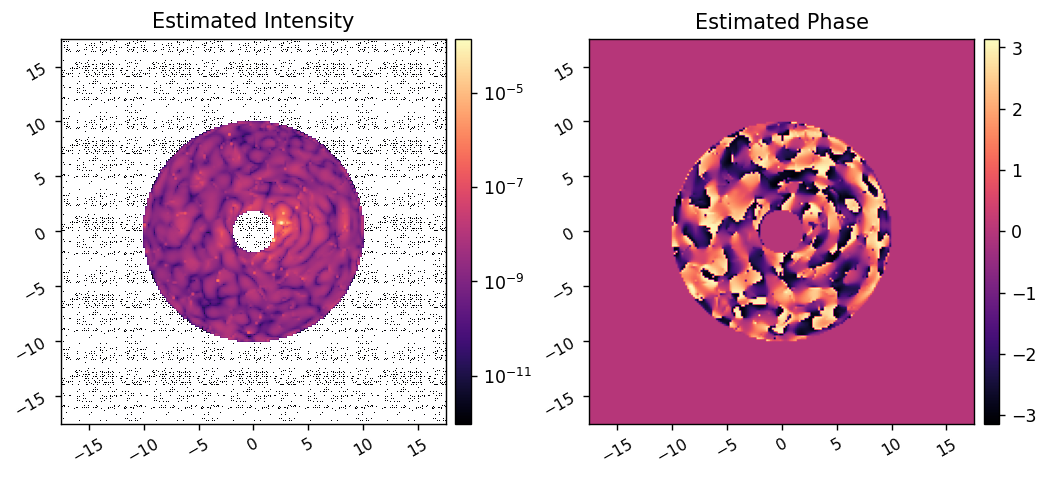

	Mean NI of this iteration: 7.965e-09


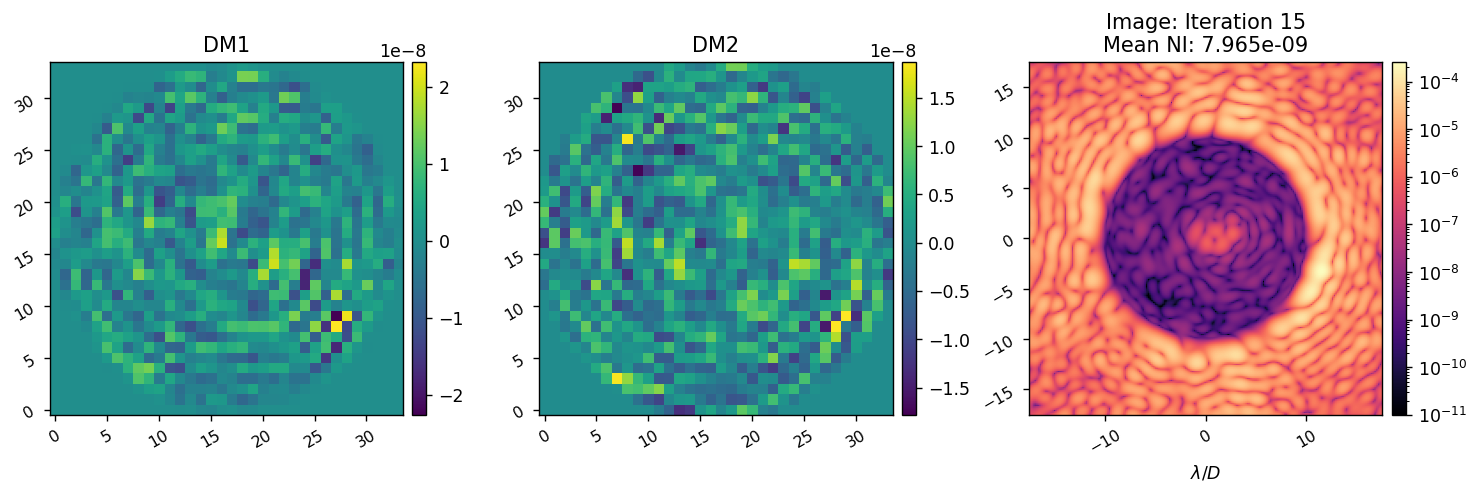

EFC completed in 33.810 sec.


In [25]:
reload(efc)

reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5


pwp_fun = pwp.run_pwp_bp

pwp_reg = 1e-8
pwp_params = {
    'control_mask':control_mask,  
    'probes':probes/3,
    'use':'J', 
    'jacobian':jac,
    'reg_cond':pwp_reg, 
    'plot_est':True,
}

images, dm1_commands, dm2_commands, regs = efc.run(coro, 
                                                    jac, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    control_mask, 
                                                    est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=dm1_commands,
                                                    old_dm2_commands=dm2_commands,
                                                    old_regs=regs,
                                                    )